# Forecasting Smoke Test Dataset

This dataset is a synthetically constructed collection designed to be used for fast testing of time series forecasting models. It includes multiple series each with distinct components to model various real-world scenarios.

A set of functions with specific seeds ensure the dataset's reproducibility. Five series are created, each comprising four key components:

1. **Sine-Wave Pattern**: A sine-wave with a time-step of pi/8 is at the core of each series, with an incrementally increasing offset to introduce variability in the phase across series. The sine-wave values range between 4 to 6 for the first series and increase by 5 for each subsequent series, simulating different baseline levels of the phenomenon under study. 

2. **Linear Trend**: Each series exhibits a unique linear trend, progressively increasing by 0.1 with each time step. This trend component represents a steady progression over time, such as growth or decay in a time series.

3. **Periodic Feature (add_step)**: A distinctive feature is introduced where at 10% of randomly chosen locations in the series, the constant value 1.5 is added, representing known events or interventions that occur at regular intervals (such as a promotion, or sale event). This event is treated like a known in advance (i.e. it is known for future periods). 

4. **Random Gaussian Noise**: To mimic natural fluctuations and introduce realism, Gaussian noise with a mean of 0 and a standard deviation of 0.1 is added to each time series.

The dataset accurately models a scenario where each series shares a common pattern due to the sine-wave but also demonstrates unique behavior through its trend, periodic feature, and noise components. The dataset's structure enables exploration and modeling of various aspects:

- **Time Series Forecasting**: The dataset's predictable yet varied components make it ideal for developing and evaluating forecasting models.

- **Pattern Recognition**: The sine-wave and linear trend components allow for the testing of algorithms that detect and exploit patterns over time.

- **Periodicity Analysis**: The `add_step` feature enables the study of algorithms' ability to recognize and predict periodic events within time series data.

The final output is a pandas DataFrame with the following columns: `series_id` (a unique identifier for each series), `sine` (the sine-wave component), `trend` (the linear-trend component), `add_step` (the periodic feature), and `y` (the final series values including noise). This composition of the dataset presents a rich, controlled environment suitable for testing and enhancing various time series analysis methods.

In [34]:
import numpy as np
import pandas as pd
import os

In [35]:
dataset_name = "smoke_test_forecasting"

In [36]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Generation Functions

In [37]:
# Define the modular functions with type hints and Google style docstrings
def generate_sine_wave(length: int, phase: float, amplitude: float) -> np.ndarray:
    """Generate the sine wave component of the time series.
    
    Args:
        length (int): The length of the time series.
        phase (float): The phase offset of the sine wave.
        amplitude (float): The amplitude of the sine wave.
        
    Returns:
        np.ndarray: The sine wave component of the time series.
    """
    return amplitude + np.sin(np.arange(0, length * time_step, time_step) + phase)


In [38]:
def generate_linear_trend(length: int, slope: float) -> np.ndarray:
    """Generate the linear trend component of the time series.
    
    Args:
        length (int): The length of the time series.
        slope (float): The slope of the linear trend.
        
    Returns:
        np.ndarray: The linear trend component of the time series.
    """
    return slope * np.arange(length)

In [39]:
def generate_add_offset_feature(length: int, percent:float, value: float) -> np.ndarray:
    """Generate the add_offset feature of the time series.
    
    Args:
        length (int): The length of the time series.
        percent (float): Percent of places to add the offset.
        value (float): The value to add every 'step' steps.
        
    Returns:
        np.ndarray: The add_offset feature of the time series.
    """
    offset_locations = np.zeros(length)
    # Choose unique random positions to set to 1
    num_locs_to_offset = int(percent * length)
    random_positions = np.random.choice(range(length), num_locs_to_offset, replace=False)
    offset_locations[random_positions] = 1
    feature = offset_locations * value
    return offset_locations, feature

In [40]:
def generate_gaussian_noise(length: int, std: float) -> np.ndarray:
    """Generate the gaussian noise component of the time series.
    
    Args:
        length (int): The length of the time series.
        std (float): The standard deviation of the gaussian noise.
        
    Returns:
        np.ndarray: The gaussian noise component of the time series.
    """
    return np.random.normal(0, std, length)

# Generate Dataset

In [41]:
# Constants
series_len = 100
time_step = np.pi / 8
sine_amplitude = 5
num_series = 5
noise_std = 0.1
offset_step = 5
offset_value = 1.5

# Create the dataframe
data = []

np.random.seed(345)

for i in range(num_series):
    series_id = i + 1
    sine = generate_sine_wave(series_len, phase=i, amplitude=series_id * sine_amplitude)
    trend = generate_linear_trend(series_len, slope=series_id * 0.01)
    offset_locations, offsets = generate_add_offset_feature(series_len, 0.1, offset_value)
    noise = generate_gaussian_noise(series_len, noise_std)
    y = sine + trend + offsets + noise
    
    temp_df = pd.DataFrame({
        'series_id': f"series_{series_id}",
        't': np.arange(series_len),
        'sine': sine,
        'trend': trend,
        'special_event': offset_locations,
        'y': y
    })
    data.append(temp_df)

# Create dataframe
data = pd.concat(data)

# Show the head of the dataframe
# data.head(10)

In [42]:
series_col = "series_id"
epoch_col = 't'
time_col = None
value_col = 'y'
exog_cols=['special_event']

# Visualize Data

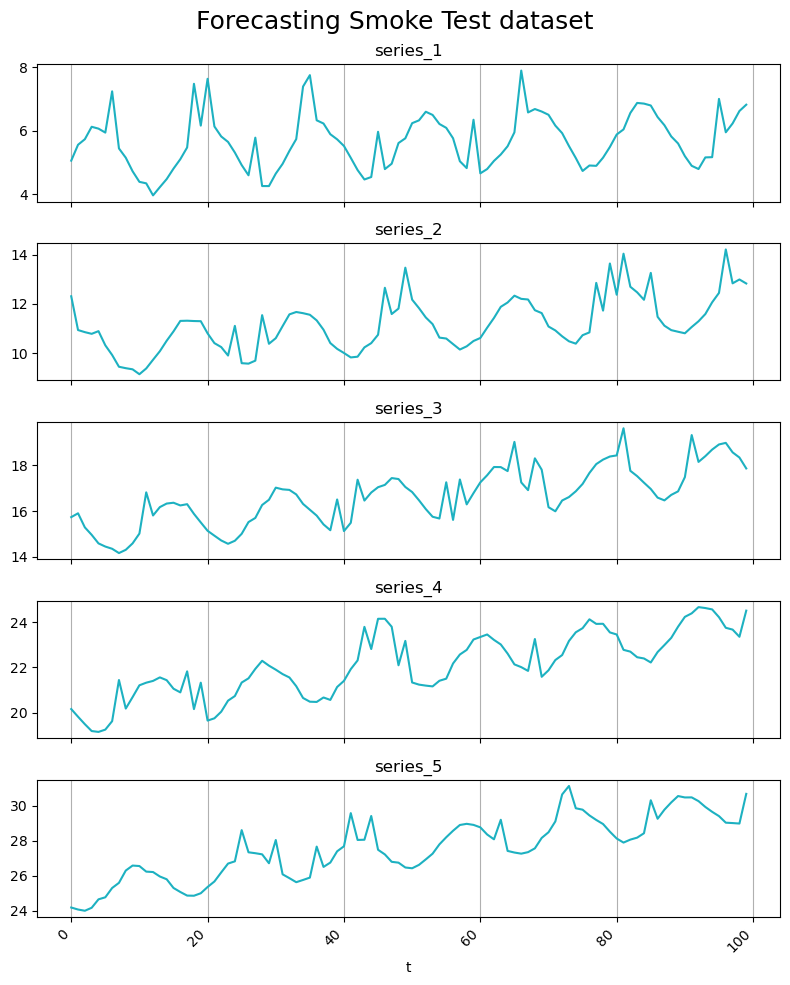

In [43]:
import matplotlib.pyplot as plt

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label='t',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="Forecasting Smoke Test dataset"
)  


# Save Main Data File

In [44]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False, float_format="%.3f")